# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [ ]:
import gymnasium as gym
import Box2D
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


In [2]:
# Exploration de l'environnement
state, info = env.reset()
print("Espace d'observation:", env.observation_space)
print("Espace d'action:", env.action_space)
print("État initial:", state)
print("Info:", info)

Espace d'observation: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Espace d'action: Discrete(2)
État initial: [-0.04134234 -0.03475324 -0.02261429  0.02900978]
Info: {}


In [3]:
# Exécution de quelques actions aléatoires
for _ in range(5):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    print(f"Action: {action}, Récompense: {reward}, Terminated: {terminated}, Next state: {next_state}")
    if terminated or truncated:
        state, info = env.reset()
        print("Environnement réinitialisé")

env_render.close()
env.close()

Action: 1, Récompense: 1.0, Terminated: False, Next state: [-0.0420374   0.1606856  -0.02203409 -0.27072155]
Action: 1, Récompense: 1.0, Terminated: False, Next state: [-0.03882369  0.35611492 -0.02744852 -0.5702719 ]
Action: 1, Récompense: 1.0, Terminated: False, Next state: [-0.03170139  0.5516108  -0.03885396 -0.87147415]
Action: 1, Récompense: 1.0, Terminated: False, Next state: [-0.02066917  0.7472391  -0.05628344 -1.1761153 ]
Action: 0, Récompense: 1.0, Terminated: False, Next state: [-0.00572439  0.5528917  -0.07980575 -0.9015944 ]


In [9]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

Épisode 10, Score moyen: 15.70, Longueur moyenne: 15.70
Épisode 20, Score moyen: 15.30, Longueur moyenne: 15.30
Épisode 30, Score moyen: 17.20, Longueur moyenne: 17.20
Épisode 40, Score moyen: 36.50, Longueur moyenne: 36.50
Épisode 50, Score moyen: 71.50, Longueur moyenne: 71.50
Épisode 60, Score moyen: 192.40, Longueur moyenne: 192.40
Épisode 70, Score moyen: 75.50, Longueur moyenne: 75.50
Épisode 80, Score moyen: 149.20, Longueur moyenne: 149.20
Épisode 90, Score moyen: 190.30, Longueur moyenne: 190.30
Épisode 100, Score moyen: 157.40, Longueur moyenne: 157.40
Épisode 110, Score moyen: 111.90, Longueur moyenne: 111.90
Épisode 120, Score moyen: 131.00, Longueur moyenne: 131.00
Épisode 130, Score moyen: 446.00, Longueur moyenne: 446.00
Épisode 140, Score moyen: 171.20, Longueur moyenne: 171.20
Épisode 150, Score moyen: 103.70, Longueur moyenne: 103.70
Épisode 160, Score moyen: 156.10, Longueur moyenne: 156.10
Épisode 170, Score moyen: 122.70, Longueur moyenne: 122.70
Épisode 180, Score

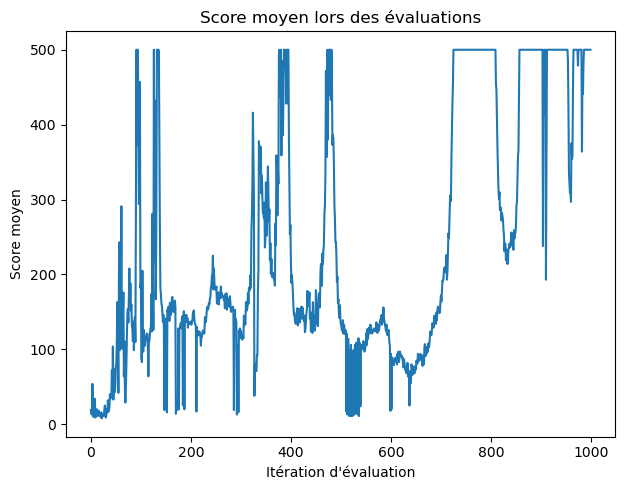

In [ ]:
# Implémentation de REINFORCE
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        return action.item(), distribution.log_prob(action)

def reinforce(env, policy, optimizer, n_episodes=1000, gamma=0.99, eval_interval=10, eval_episodes=10):
    """
    Train a policy using REINFORCE and periodically evaluate agent performance.

    Args:
        env: Gymnasium environment.
        policy: PolicyNetwork instance.
        optimizer: Optimizer for policy.
        n_episodes: Total training episodes.
        gamma: Discount factor.
        eval_interval: Evaluate every N episodes.
        eval_episodes: Number of episodes to run during evaluation.

    Returns:
        scores: List of training episode rewards.
        eval_scores: List of average rewards from evaluation.
        eval_lengths: List of average episode lengths from evaluation.
    """
    
    scores = []
    eval_scores = []
    eval_lengths = []
    
    for episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False
        score = 0
        
        while not done:
            action, log_prob = policy.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            score += reward
        
        scores.append(score)
        
        # Calcul des retours actualisés
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        
        # Normalisation des retours
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        # Calcul de la perte
        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        policy_loss = torch.cat(policy_loss).sum()
        
        # Mise à jour de la politique
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        # Évaluation périodique
        if episode % eval_interval == 0:
            avg_score, avg_length = evaluate_policy(env, policy, eval_episodes)
            eval_scores.append(avg_score)
            eval_lengths.append(avg_length)
            print(f"Épisode {episode}, Score moyen: {avg_score:.2f}")
    
    return scores, eval_scores

def evaluate_policy(env, policy, n_episodes=10):
    total_rewards = []
    total_lengths = []
    
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            action, _ = policy.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            state = next_state
            total_reward += reward
            steps += 1
        
        total_rewards.append(total_reward)
        total_lengths.append(steps)
    
    return np.mean(total_rewards), np.mean(total_lengths)

# Entraînement de l'agent
policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

scores, eval_scores = reinforce(env, policy, optimizer, n_episodes=1000)

# Visualisation des résultats
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(scores)
plt.title('Score moyen lors des évaluations')
plt.xlabel('Itération d\'évaluation')
plt.ylabel('Score moyen')
"""
plt.subplot(1, 2, 2)
plt.plot(eval_lengths)
plt.title('Longueur moyenne des épisodes lors des évaluations')
plt.xlabel('Itération d\'évaluation')
plt.ylabel('Longueur moyenne')
"""
plt.tight_layout()
plt.show()

In [35]:
# Your code here. Call .reset() on the environment and inspect the output. Also, check out the observation_space.

**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

In [36]:
# Your code here. You should be able to train an agent to solve Cartpole. This will be our starting point.

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

In [ ]:
# Your code here.

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [52]:
def reinforce(env, policy, optimizer, n_episodes=1000, gamma=0.99, eval_interval=50, eval_episodes=10, use_standardize_baseline=True):
    """
    Train a policy using REINFORCE and periodically evaluate agent performance.
    Optionally use standardized baseline (subtract mean and divide by std of returns).

    Args:
        env: Gymnasium environment.
        policy: PolicyNetwork instance.
        optimizer: Optimizer for policy.
        n_episodes: Total training episodes.
        gamma: Discount factor.
        eval_interval: Evaluate every N episodes.
        eval_episodes: Number of episodes to run during evaluation.
        use_standardize_baseline: If True, use standardized baseline.

    Returns:
        scores: List of training episode rewards.
        eval_scores: List of average rewards from evaluation.
        eval_lengths: List of average episode lengths from evaluation.
    """
    scores = []
    eval_scores = []
    eval_lengths = []

    for episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False
        score = 0

        while not done:
            action, log_prob = policy.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            score += reward

        scores.append(score)

        # Compute discounted returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)

        if use_standardize_baseline:
            # Standardize returns: subtract mean and divide by std
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Compute policy loss
        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        policy_loss = torch.cat(policy_loss).sum()

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Periodic evaluation
        if episode % eval_interval == 0:
            avg_score, avg_length = evaluate_policy(env, policy, eval_episodes)
            eval_scores.append(avg_score)
            eval_lengths.append(avg_length)
            print(f"Épisode {episode}, Score moyen: {avg_score:.2f}")

    return scores, eval_scores

Épisode 50, Score moyen: 26.10
Épisode 100, Score moyen: 167.30
Épisode 150, Score moyen: 500.00
Épisode 200, Score moyen: 481.90
Épisode 250, Score moyen: 500.00
Épisode 300, Score moyen: 500.00
Épisode 350, Score moyen: 175.60
Épisode 400, Score moyen: 500.00
Épisode 450, Score moyen: 500.00
Épisode 500, Score moyen: 500.00
Épisode 550, Score moyen: 279.90
Épisode 600, Score moyen: 500.00
Épisode 650, Score moyen: 500.00
Épisode 700, Score moyen: 500.00
Épisode 750, Score moyen: 500.00
Épisode 800, Score moyen: 500.00
Épisode 850, Score moyen: 500.00
Épisode 900, Score moyen: 500.00
Épisode 950, Score moyen: 39.30
Épisode 1000, Score moyen: 25.50


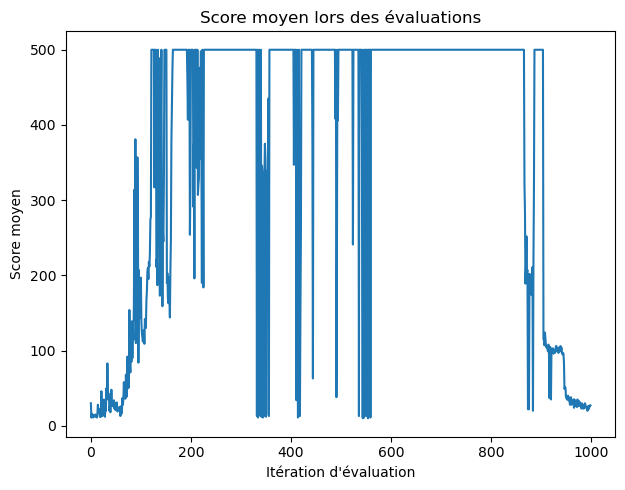

In [53]:
# Your code here. Modify your implementation of `REINFORCE` to optionally use the standardize baseline.
# Entraînement de l'agent
policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

scores, eval_scores = reinforce(env, policy, optimizer, n_episodes=1000)

# Visualisation des résultats
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(scores)
plt.title('Score moyen lors des évaluations')
plt.xlabel('Itération d\'évaluation')
plt.ylabel('Score moyen')
"""
plt.subplot(1, 2, 2)
plt.plot(eval_lengths)
plt.title('Longueur moyenne des épisodes lors des évaluations')
plt.xlabel('Itération d\'évaluation')
plt.ylabel('Longueur moyenne')
"""
plt.tight_layout()
plt.show()

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [10]:
# -----------------------------
# Policy Network
# -----------------------------
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return F.softmax(logits, dim=-1)

# -----------------------------
# Value Network (baseline)
# -----------------------------
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# -----------------------------
# Evaluation helper
# -----------------------------
def evaluate_agent(env, policy_net, M=5, render=False):
    total_rewards = []
    lengths = []

    for _ in range(M):
        state = env.reset()[0]
        done, truncated = False, False
        ep_reward = 0
        ep_length = 0

        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                probs = policy_net(state_tensor)
            action = torch.distributions.Categorical(probs).sample().item()

            state, reward, done, truncated, _ = env.step(action)
            ep_reward += reward
            ep_length += 1

            if render:
                env.render()

        total_rewards.append(ep_reward)
        lengths.append(ep_length)

    avg_reward = sum(total_rewards) / M
    avg_length = sum(lengths) / M
    return avg_reward, avg_length


# -----------------------------
# REINFORCE with baseline
# -----------------------------
def reinforce(env_name="CartPole-v1", num_episodes=1000, gamma=0.99, lr=1e-3,
              eval_interval=10, eval_episodes=10):
    env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = PolicyNetwork(state_dim, action_dim)
    value_net = ValueNetwork(state_dim)

    optimizer = optim.Adam(
        list(policy_net.parameters()) + list(value_net.parameters()), lr=lr
    )

    eval_rewards = []
    eval_lengths = []
    scores = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        log_probs, rewards, states = [], [], []
        score = 0

        done, truncated = False, False
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy_net(state_tensor)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            next_state, reward, done, truncated, _ = env.step(action.item())

            log_probs.append(dist.log_prob(action))
            rewards.append(reward)
            states.append(state_tensor)
            score += reward

            state = next_state

        scores.append(score)

        # Compute returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)

        # Normalize returns
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Compute losses
        policy_loss = 0
        value_loss = 0
        for log_prob, G, s in zip(log_probs, returns, states):
            baseline = value_net(s)
            advantage = G - baseline.item()

            policy_loss += -log_prob * advantage
            value_loss += F.mse_loss(baseline.squeeze(), torch.tensor([G]))

        loss = policy_loss + value_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Evaluation every N episodes ---
        if (episode + 1) % eval_interval == 0:
            avg_reward, avg_length = evaluate_agent(env, policy_net, M=eval_episodes)
            eval_rewards.append(avg_reward)
            eval_lengths.append(avg_length)
            print(f"[Eval after {episode+1} episodes], Avg Reward: {avg_reward:.2f}")

    env.close()
    return scores, eval_rewards

C:\Users\loric\AppData\Local\Temp\ipykernel_28448\3347567773.py:126: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss += F.mse_loss(baseline.squeeze(), torch.tensor([G]))


[Eval after 100 episodes], Avg Reward: 57.20
[Eval after 200 episodes], Avg Reward: 70.60
[Eval after 300 episodes], Avg Reward: 93.00
[Eval after 400 episodes], Avg Reward: 401.60
[Eval after 500 episodes], Avg Reward: 359.00
[Eval after 600 episodes], Avg Reward: 292.80
[Eval after 700 episodes], Avg Reward: 455.00
[Eval after 800 episodes], Avg Reward: 500.00
[Eval after 900 episodes], Avg Reward: 492.40
[Eval after 1000 episodes], Avg Reward: 487.20


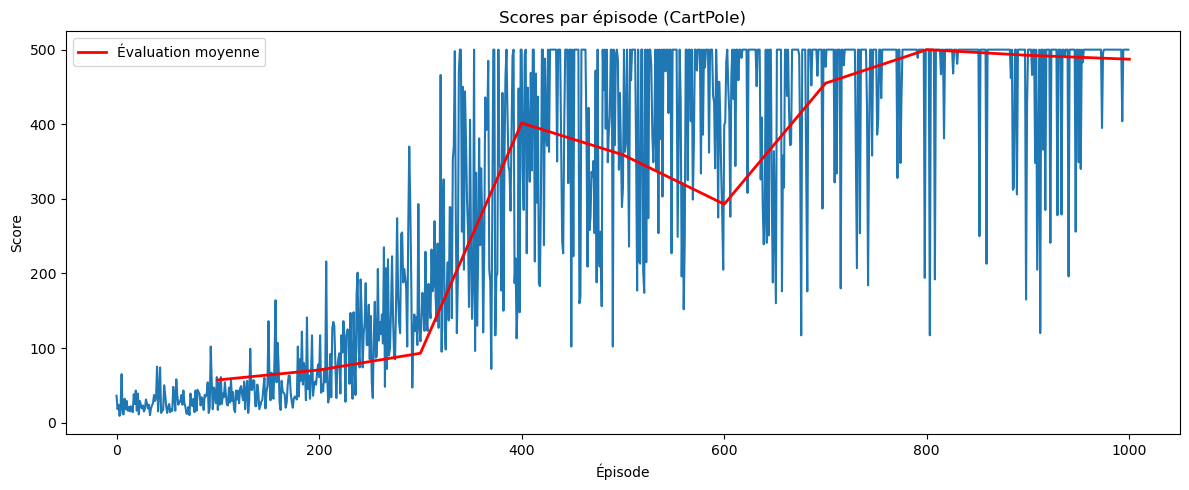

In [65]:
scores, eval_scores = reinforce(eval_interval=100, eval_episodes=5)

plt.figure(figsize=(12, 5))
plt.plot(scores)
plt.title('Scores par épisode (CartPole)')
plt.xlabel('Épisode')
plt.ylabel('Score')

# --- Courbe des évaluations moyennes ---
eval_x = [i * 100 for i in range(1, len(eval_scores) + 1)]  # épisodes où les evals ont eu lieu
plt.plot(eval_x, eval_scores, label="Évaluation moyenne", color="red", linewidth=2)

plt.legend()
plt.tight_layout()
plt.show()

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

C:\Users\loric\AppData\Local\Temp\ipykernel_30556\3347567773.py:126: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss += F.mse_loss(baseline.squeeze(), torch.tensor([G]))


[Eval after 100 episodes], Avg Reward: -164.14
[Eval after 200 episodes], Avg Reward: -169.24
[Eval after 300 episodes], Avg Reward: -132.35
[Eval after 400 episodes], Avg Reward: -98.65
[Eval after 500 episodes], Avg Reward: -66.70
[Eval after 600 episodes], Avg Reward: -1.74
[Eval after 700 episodes], Avg Reward: -41.25
[Eval after 800 episodes], Avg Reward: 4.24
[Eval after 900 episodes], Avg Reward: -21.46
[Eval after 1000 episodes], Avg Reward: 39.05
[Eval after 1100 episodes], Avg Reward: 76.74
[Eval after 1200 episodes], Avg Reward: 87.09
[Eval after 1300 episodes], Avg Reward: 78.88
[Eval after 1400 episodes], Avg Reward: 111.33
[Eval after 1500 episodes], Avg Reward: 87.42
[Eval after 1600 episodes], Avg Reward: 97.96
[Eval after 1700 episodes], Avg Reward: 110.71
[Eval after 1800 episodes], Avg Reward: 137.89
[Eval after 1900 episodes], Avg Reward: 141.77
[Eval after 2000 episodes], Avg Reward: 132.64
[Eval after 2100 episodes], Avg Reward: 121.90
[Eval after 2200 episodes], 

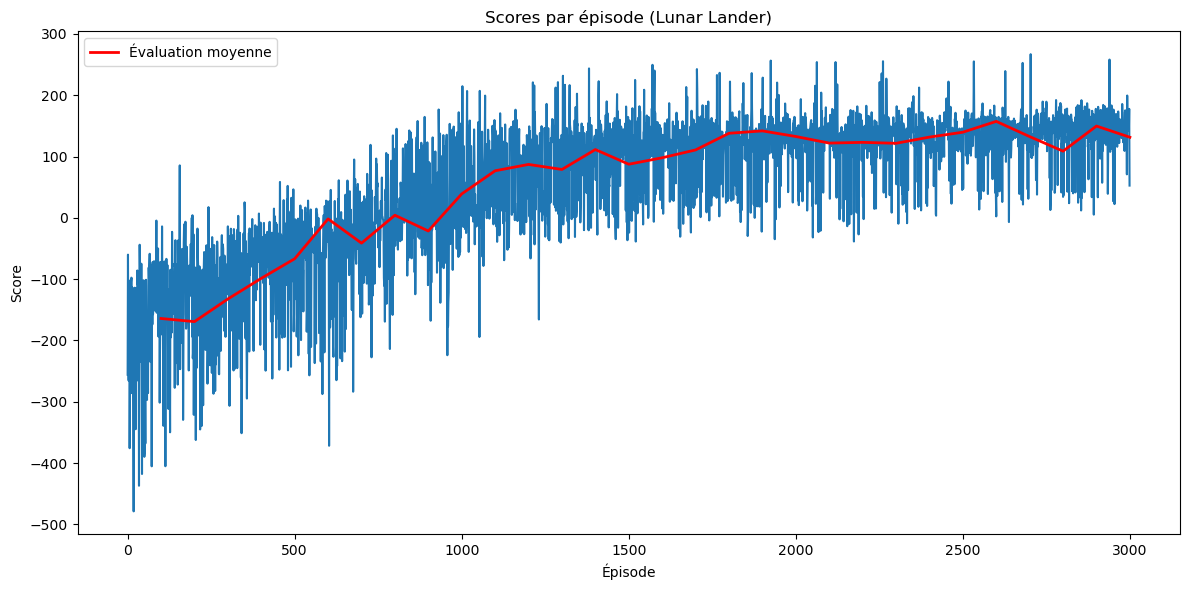

: 

In [ ]:
# Lunar Lander avec REINFORCE
# Entraîner l'agent avec REINFORCE

scores_lunar, eval_scores_lunar = reinforce(env_name='LunarLander-v2', num_episodes=3000 , eval_interval=100, eval_episodes=10)

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(scores_lunar)
plt.title('Scores par épisode (Lunar Lander)')
plt.xlabel('Épisode')
plt.ylabel('Score')

# --- Courbe des évaluations moyennes ---
eval_x_lunar = [i * 100 for i in range(1, len(eval_scores_lunar) + 1)]  # épisodes où les evals ont eu lieu
plt.plot(eval_x_lunar, eval_scores_lunar, label="Évaluation moyenne", color="red", linewidth=2)

plt.legend()
plt.tight_layout()
plt.show()

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.